In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from scipy import misc

import os
from tqdm import tqdm 

In [2]:
# the folder from test.zip file
dir_test = '/home/ubuntu/test/'

# Collect metadata

In [3]:
files = list(os.walk(dir_test))[0][2]
files

# collect test metadata
test_metadata = []
    
for file_name in tqdm(files):
    if not file_name.startswith('.'):
        # read image
        temp = misc.imread(os.path.join(dir_test, file_name)) 
        # collect image metadata
        image_metadata = [file_name]
        image_metadata.extend( 
            list(temp.shape) if len(temp.shape) == 3 
            else [temp.shape[0], temp.shape[1], 1]
        )
        image_metadata.extend([temp.nbytes, temp.dtype])
        # append image metadata to list
        test_metadata.append(image_metadata)

100%|██████████| 7710/7710 [00:24<00:00, 292.56it/s]


# Explore metadata

In [4]:
M = pd.DataFrame(test_metadata)
M.columns = ['img_name', 'height', 'width', 'channels', 'byte_size', 'bit_depth']

M['img_extension'] = M['img_name'].apply(lambda x: x.split('.')[-1])

In [5]:
# number of grayscale images
(M.channels != 3).sum()

124

In [6]:
M.img_extension.unique()

array(['jpg'], dtype=object)

In [7]:
M.bit_depth.unique()

array([dtype('uint8')], dtype=object)

# Resize images

In [8]:
n_images = len(M)
n_images

7710

In [9]:
# new image shape: 224, 224
images = np.zeros((n_images, 224, 224, 3), dtype='uint8')
numbers = np.zeros((n_images,), dtype='object')

In [10]:
# resize RGB images
for i, row in tqdm(M.loc[M.channels == 3].iterrows()):
    # get image and resize it
    file_path = os.path.join(dir_test, row.img_name)
    image = Image.open(file_path).resize((224, 224), Image.LANCZOS)
    # convert to array
    array = np.asarray(image, dtype='uint8')
    
    images[i] = array
    numbers[i] = row.img_name[:-4]

7586it [00:51, 148.40it/s]


In [11]:
# resize grayscale images
for i, row in tqdm(M.loc[M.channels == 1].iterrows()):
    file_path = os.path.join(dir_test, row.img_name)
    image = Image.open(file_path).resize((224, 224), Image.LANCZOS)
    array = np.asarray(image, dtype='uint8')
    # convert to RGB
    array = np.stack([array, array, array], axis=2)
    images[i] = array
    numbers[i] = row.img_name[:-4]

124it [00:00, 252.41it/s]


# Show some resized RGB images

In [12]:
# choose random images
to_show = np.random.choice(np.arange(0, n_images), size=2*4)

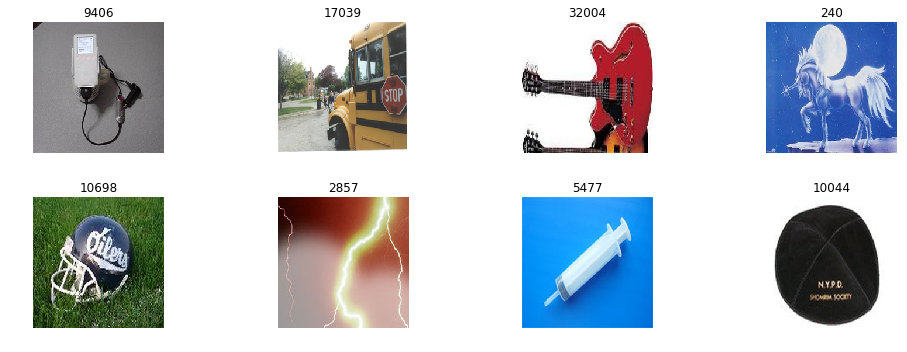

In [13]:
_, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 5))
axes = axes.flatten()
for i, j in enumerate(to_show):
    axes[i].set_axis_off();
    axes[i].imshow(images[j]/255);
    axes[i].set_title(numbers[j]);
plt.tight_layout()

# Show some resized grayscale images

In [14]:
gray_indices = list(M.loc[(M.channels == 1)].index)

In [15]:
to_show = np.random.choice(gray_indices, size=2*4)

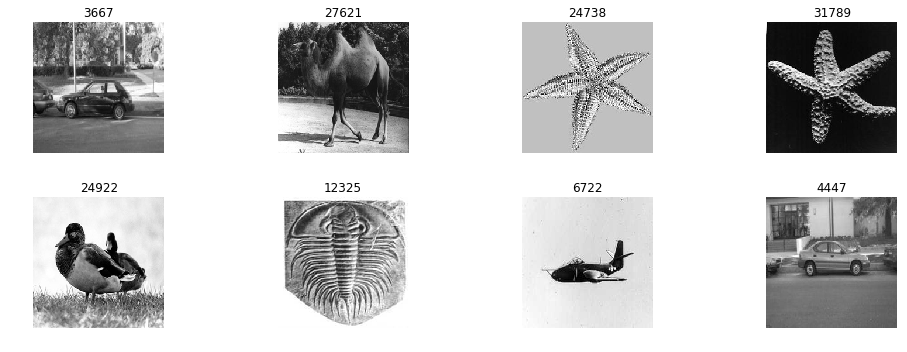

In [16]:
_, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 5))
axes = axes.flatten()
for i, j in enumerate(to_show):
    axes[i].set_axis_off();
    axes[i].imshow(images[j]/255);
    axes[i].set_title(numbers[j]);
plt.tight_layout()

# Save

In [17]:
np.save('test_images.npy', images) # size: 1.1 GB
np.save('test_file_names.npy', numbers)